In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

CUDA = True
DATA_PATH = "./work/data"
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 5
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 0.0002
seed = 1

CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.6.0+cpu


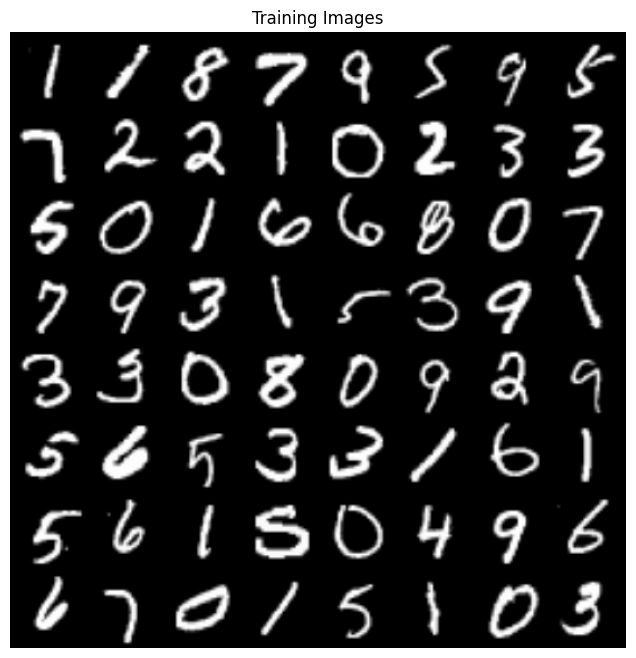

In [2]:
# Data preprocessing
dataset = dset.MNIST(
    root=DATA_PATH,
    download=True,
    transform=transforms.Compose(
        [
            transforms.Resize(X_DIM),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [5]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [6]:
def train_gan(dataloader, netD, netG, criterion, optimizerD, optimizerG, device, EPOCH_NUM, Z_DIM, REAL_LABEL, FAKE_LABEL, viz_noise):
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    for epoch in range(EPOCH_NUM):
        for i, data in enumerate(dataloader, 0):

            # (1) Update the discriminator with real data
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            # (2) Update the discriminator with fake data
            # Generate batch of latent vectors
            noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(FAKE_LABEL)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            # (3) Update the generator with fake data
            netG.zero_grad()
            label.fill_(REAL_LABEL)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print(
                    "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                    % (
                        epoch,
                        EPOCH_NUM,
                        i,
                        len(dataloader),
                        errD.item(),
                        errG.item(),
                        D_x,
                        D_G_z1,
                        D_G_z2,
                    )
                )

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or (
                (epoch == EPOCH_NUM - 1) and (i == len(dataloader) - 1)
            ):
                with torch.no_grad():
                    fake = netG(viz_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    return img_list, G_losses, D_losses

In [7]:
def plot_training_results(G_losses, D_losses, dataloader, img_list, device):
    # Plot the generator and discriminator loss
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(
                real_batch[0].to(device)[:64], padding=5, normalize=True
            ).cpu(),
            (1, 2, 0),
        )
    )

    # Plot the fake images from the last epoch
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    plt.show()

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.3662	Loss_G: 4.7382	D(x): 0.5841	D(G(z)): 0.4732 / 0.0130
[0/5][50/469]	Loss_D: 0.1517	Loss_G: 14.3251	D(x): 0.9166	D(G(z)): 0.0001 / 0.0000
[0/5][100/469]	Loss_D: 0.0481	Loss_G: 7.4620	D(x): 0.9799	D(G(z)): 0.0211 / 0.0008
[0/5][150/469]	Loss_D: 2.8720	Loss_G: 12.5093	D(x): 0.1539	D(G(z)): 0.0000 / 0.0001
[0/5][200/469]	Loss_D: 0.0982	Loss_G: 4.1357	D(x): 0.9499	D(G(z)): 0.0404 / 0.0202
[0/5][250/469]	Loss_D: 0.1760	Loss_G: 4.5269	D(x): 0.9572	D(G(z)): 0.1160 / 0.0197
[0/5][300/469]	Loss_D: 0.7192	Loss_G: 2.0200	D(x): 0.6006	D(G(z)): 0.0770 / 0.1941
[0/5][350/469]	Loss_D: 0.1067	Loss_G: 3.6813	D(x): 0.9357	D(G(z)): 0.0351 / 0.0366
[0/5][400/469]	Loss_D: 0.1315	Loss_G: 4.3067	D(x): 0.9668	D(G(z)): 0.0883 / 0.0209
[0/5][450/469]	Loss_D: 0.4626	Loss_G: 2.4554	D(x): 0.8108	D(G(z)): 0.1974 / 0.1087
[1/5][0/469]	Loss_D: 0.3489	Loss_G: 2.7777	D(x): 0.8774	D(G(z)): 0.1757 / 0.0852
[1/5][50/469]	Loss_D: 0.3290	Loss_G: 3.1242	D(x): 0.8792	D(G(z))

/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[4/5][0/469]	Loss_D: 0.2881	Loss_G: 2.4773	D(x): 0.7993	D(G(z)): 0.0420 / 0.1145
[4/5][50/469]	Loss_D: 0.6505	Loss_G: 2.2552	D(x): 0.7683	D(G(z)): 0.2806 / 0.1272
[4/5][100/469]	Loss_D: 0.2449	Loss_G: 3.0972	D(x): 0.8746	D(G(z)): 0.0904 / 0.0589
[4/5][150/469]	Loss_D: 0.4237	Loss_G: 2.7393	D(x): 0.7912	D(G(z)): 0.1388 / 0.0877
[4/5][200/469]	Loss_D: 0.1897	Loss_G: 4.8965	D(x): 0.9763	D(G(z)): 0.1398 / 0.0123
[4/5][250/469]	Loss_D: 0.1553	Loss_G: 4.2537	D(x): 0.9569	D(G(z)): 0.0949 / 0.0209
[4/5][300/469]	Loss_D: 0.6534	Loss_G: 1.6430	D(x): 0.6260	D(G(z)): 0.1078 / 0.2454
[4/5][350/469]	Loss_D: 0.5172	Loss_G: 1.7261	D(x): 0.6506	D(G(z)): 0.0325 / 0.2425
[4/5][400/469]	Loss_D: 0.3704	Loss_G: 2.5477	D(x): 0.7933	D(G(z)): 0.1054 / 0.1094
[4/5][450/469]	Loss_D: 0.1355	Loss_G: 3.5873	D(x): 0.9653	D(G(z)): 0.0892 / 0.0384


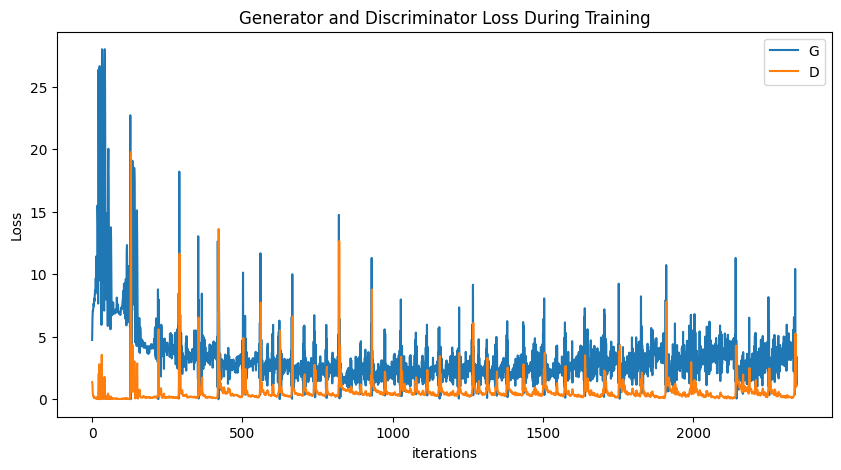

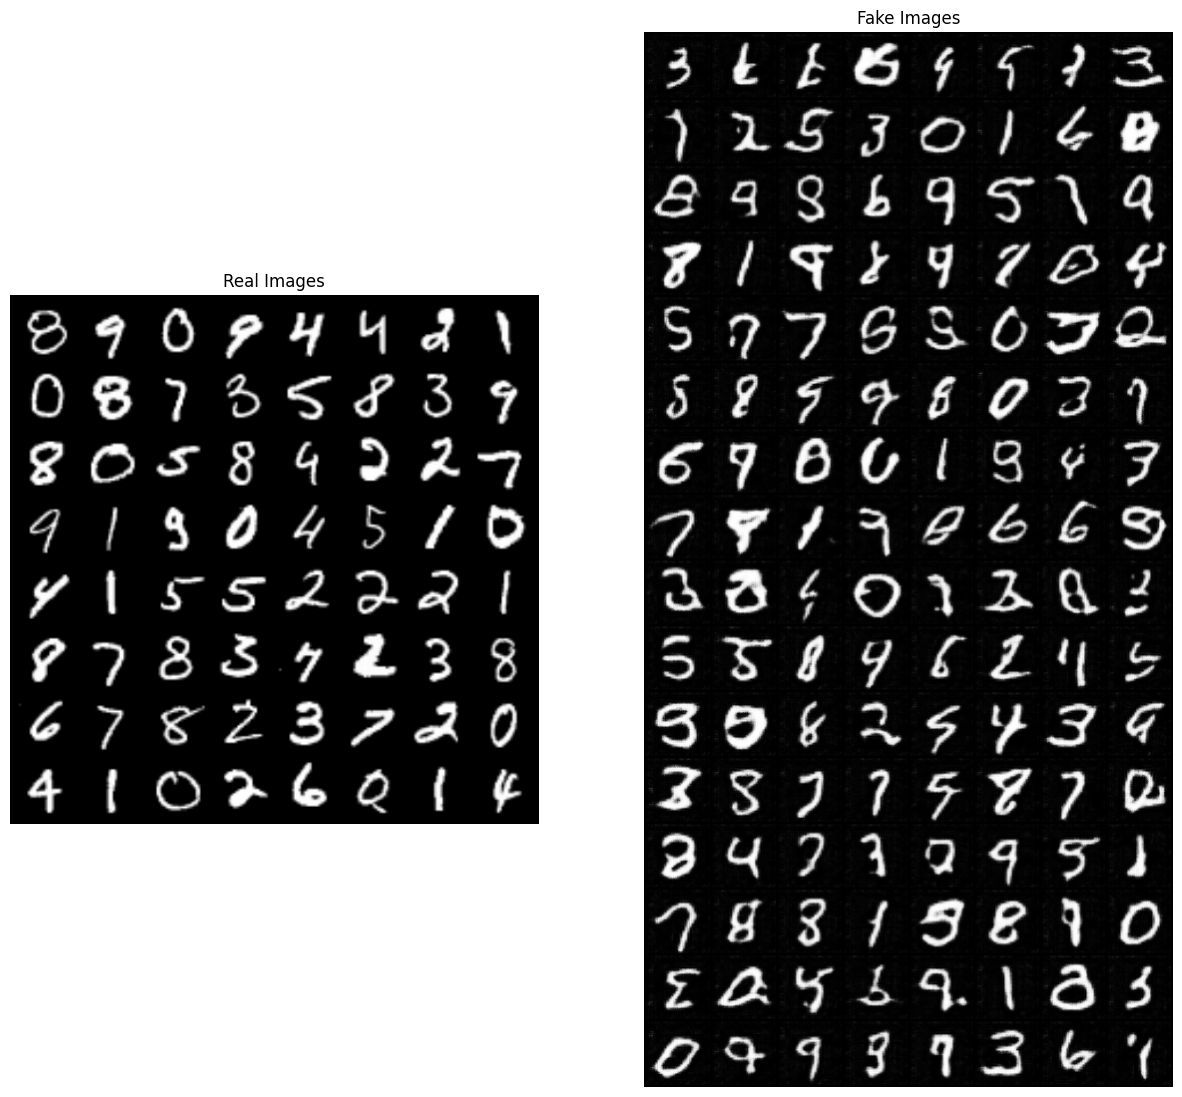

In [8]:
img_list, G_losses, D_losses = train_gan(
    dataloader=dataloader,
    netD=netD,
    netG=netG,
    criterion=criterion,
    optimizerD=optimizerD,
    optimizerG=optimizerG,
    device=device,
    EPOCH_NUM=EPOCH_NUM,
    Z_DIM=Z_DIM,
    REAL_LABEL=REAL_LABEL,
    FAKE_LABEL=FAKE_LABEL,
    viz_noise=viz_noise,
)
plot_training_results(
    G_losses=G_losses,
    D_losses=D_losses,
    dataloader=dataloader,
    img_list=img_list,
    device=device,
)

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.5154	Loss_G: 2.2404	D(x): 0.6670	D(G(z)): 0.5628 / 0.1539
[0/5][50/469]	Loss_D: 0.1107	Loss_G: 4.1337	D(x): 0.9408	D(G(z)): 0.0408 / 0.0303
[0/5][100/469]	Loss_D: 2.8260	Loss_G: 0.8984	D(x): 0.1236	D(G(z)): 0.0001 / 0.5574
[0/5][150/469]	Loss_D: 0.7341	Loss_G: 4.2379	D(x): 0.8900	D(G(z)): 0.3893 / 0.0236
[0/5][200/469]	Loss_D: 1.4082	Loss_G: 5.3598	D(x): 0.9871	D(G(z)): 0.6455 / 0.0180
[0/5][250/469]	Loss_D: 0.4448	Loss_G: 5.5165	D(x): 0.9693	D(G(z)): 0.2965 / 0.0064
[0/5][300/469]	Loss_D: 0.1176	Loss_G: 4.5811	D(x): 0.9732	D(G(z)): 0.0820 / 0.0165
[0/5][350/469]	Loss_D: 0.3321	Loss_G: 2.7490	D(x): 0.7865	D(G(z)): 0.0391 / 0.1065
[0/5][400/469]	Loss_D: 0.2611	Loss_G: 4.9411	D(x): 0.9925	D(G(z)): 0.2047 / 0.0114
[0/5][450/469]	Loss_D: 0.4184	Loss_G: 2.4854	D(x): 0.8437	D(G(z)): 0.1816 / 0.1214
[1/5][0/469]	Loss_D: 1.6550	Loss_G: 5.2768	D(x): 0.9814	D(G(z)): 0.7318 / 0.0108
[1/5][50/469]	Loss_D: 0.6539	Loss_G: 1.9290	D(x): 0.7180	D(G(z)): 

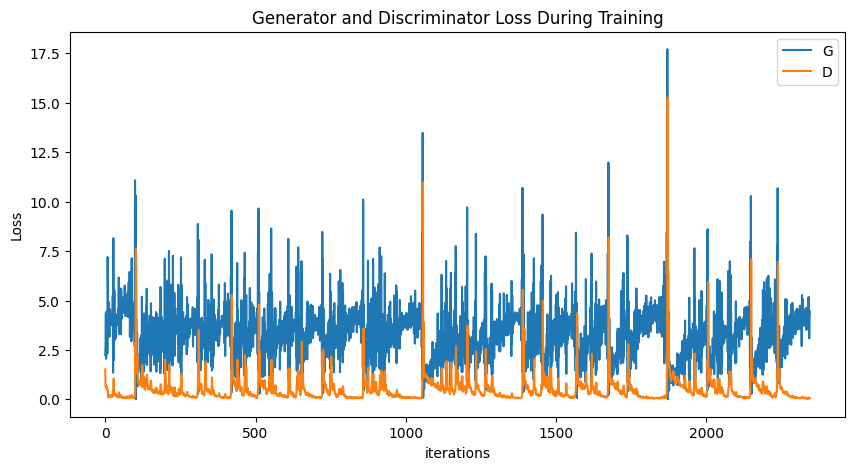

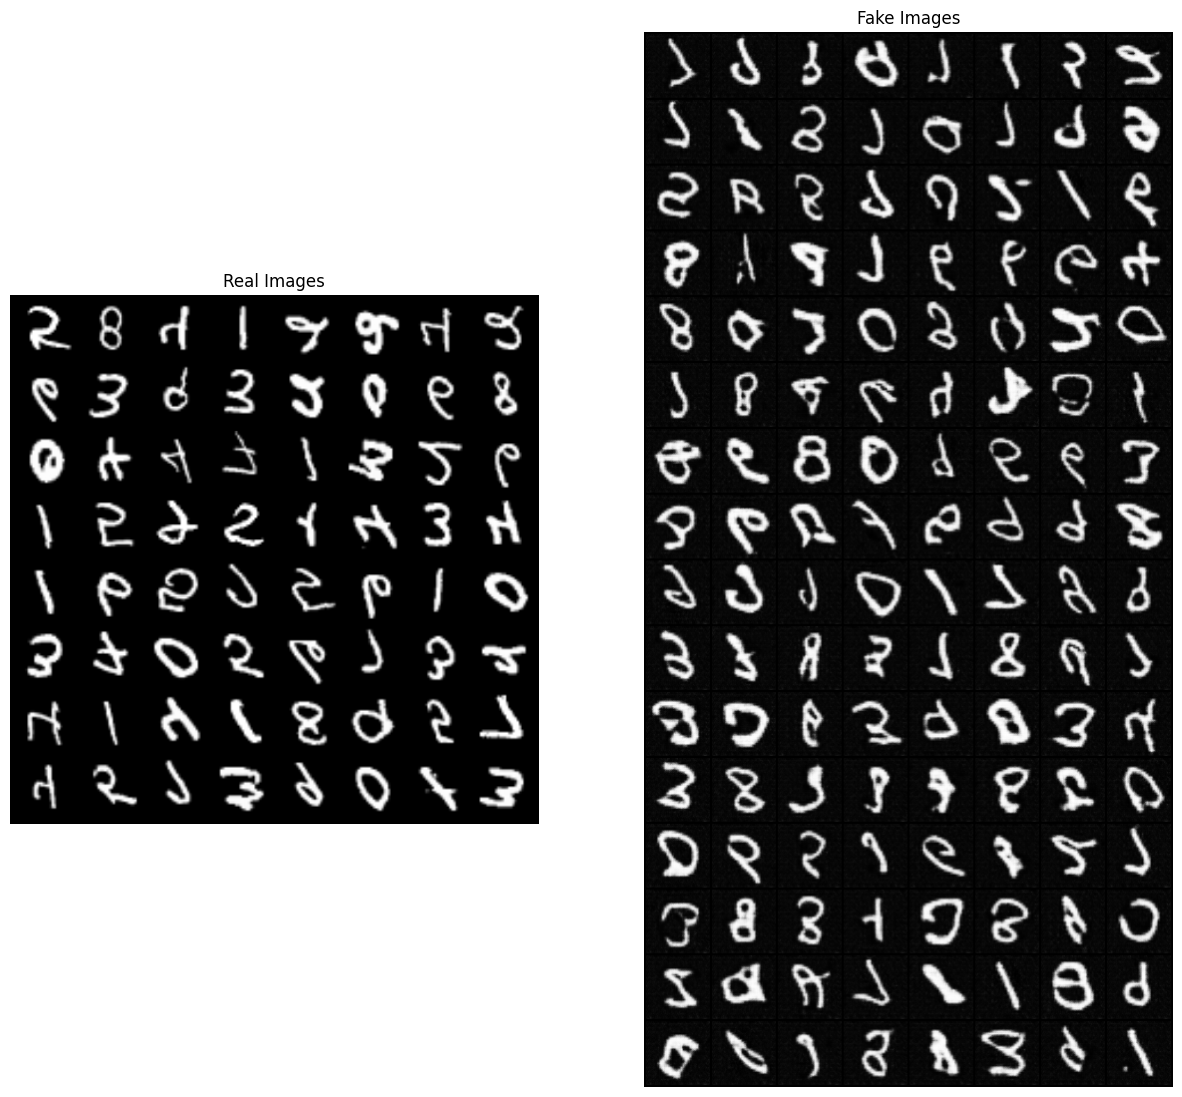

In [10]:
dataset = dset.MNIST(
    root=DATA_PATH,
    download=True,
    transform=transforms.Compose(
        [
            transforms.Resize(X_DIM),
            transforms.RandomVerticalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
img_list, G_losses, D_losses = train_gan(
    dataloader=dataloader,
    netD=netD,
    netG=netG,
    criterion=criterion,
    optimizerD=optimizerD,
    optimizerG=optimizerG,
    device=device,
    EPOCH_NUM=EPOCH_NUM,
    Z_DIM=Z_DIM,
    REAL_LABEL=REAL_LABEL,
    FAKE_LABEL=FAKE_LABEL,
    viz_noise=viz_noise,
)
plot_training_results(
    G_losses=G_losses,
    D_losses=D_losses,
    dataloader=dataloader,
    img_list=img_list,
    device=device,
)

Generator32(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator32(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4

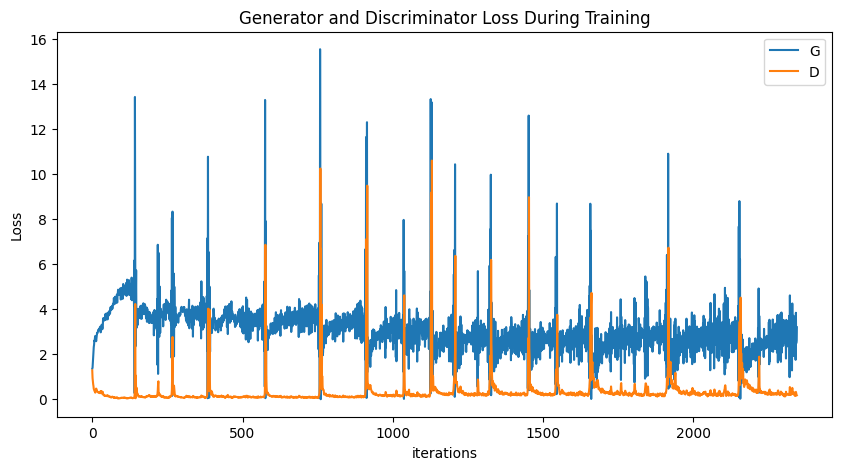

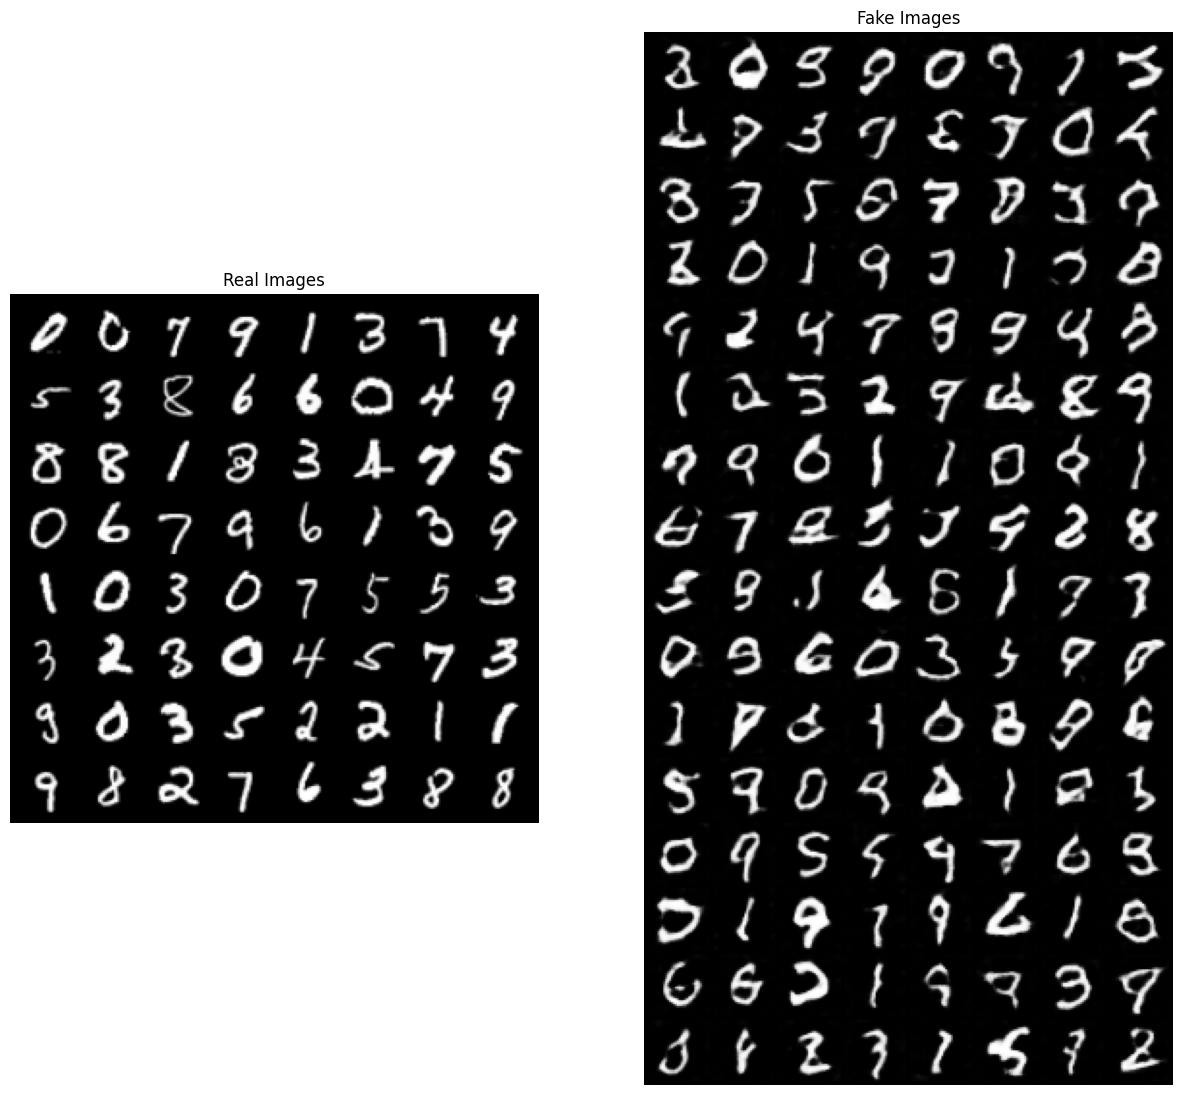

In [8]:
dataset = dset.MNIST(
    root=DATA_PATH,
    download=True,
    transform=transforms.Compose(
        [
            transforms.Resize(32),  # 调整为 32x32
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
class Generator32(nn.Module):
    def __init__(self):
        super(Generator32, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)

class Discriminator32(nn.Module):
    def __init__(self):
        super(Discriminator32, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(D_HIDDEN * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

netG = Generator32().to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator32().to(device)
netD.apply(weights_init)
print(netD)
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))


img_list, G_losses, D_losses = train_gan(
    dataloader=dataloader,
    netD=netD,
    netG=netG,
    criterion=criterion,
    optimizerD=optimizerD,
    optimizerG=optimizerG,
    device=device,
    EPOCH_NUM=EPOCH_NUM,
    Z_DIM=Z_DIM,
    REAL_LABEL=REAL_LABEL,
    FAKE_LABEL=FAKE_LABEL,
    viz_noise=viz_noise,
)

plot_training_results(
    G_losses=G_losses,
    D_losses=D_losses,
    dataloader=dataloader,
    img_list=img_list,
    device=device,
)